In [1]:
import pandas as pd
import numpy as np

# === 1) Source workbook where Gold sheets live ===
src = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis.xlsx"

# === 2) Helper to parse Bloomberg-style sheets (Dates/PX_LAST header) ===
def parse_bbg_sheet(df_raw):
    header_row = None
    for i, row in df_raw.iterrows():
        if (row.astype(str) == 'Dates').any() and (row.astype(str) == 'PX_LAST').any():
            header_row = i
            break
    if header_row is None:
        raise ValueError("Could not find 'Dates'/'PX_LAST' header row.")
    df = df_raw.iloc[header_row:]
    df.columns = df.iloc[0]
    df = df.iloc[1:, :][['Dates', 'PX_LAST']].copy()
    df['Dates'] = pd.to_datetime(df['Dates'])
    df['PX_LAST'] = pd.to_numeric(df['PX_LAST'], errors='coerce')
    df = df.dropna(subset=['Dates']).set_index('Dates').sort_index()
    return df.rename(columns={'PX_LAST': 'Gold_CHF_Last'})

# === 3) Load Gold sheets ===
with pd.ExcelFile(src, engine="openpyxl") as xl:
    gold_d_raw = xl.parse("GoldCHF daily", header=None)
    gold_w_raw = xl.parse("GoldCHF weekly", header=None)

gold_d = parse_bbg_sheet(gold_d_raw)   # index=Date, col 'Gold_CHF_Last'
gold_w = parse_bbg_sheet(gold_w_raw)

# === 4) Compute log returns (daily & weekly) ===
gold_d['Gold_ret'] = np.log(gold_d['Gold_CHF_Last']).diff()
gold_w['Gold_ret'] = np.log(gold_w['Gold_CHF_Last']).diff()

gold_d = gold_d.dropna(subset=['Gold_ret'])
gold_w = gold_w.dropna(subset=['Gold_ret'])

# === 5) Save neat outputs ===
out = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis_GoldCHF_returns.xlsx"
with pd.ExcelWriter(out, engine='openpyxl') as writer:
    gold_d.to_excel(writer, sheet_name="GoldCHF daily + ret")
    gold_w.to_excel(writer, sheet_name="GoldCHF weekly + ret")

print("✅ Gold (CHF) returns saved to:", out)


✅ Gold (CHF) returns saved to: C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis_GoldCHF_returns.xlsx


=== Daily GOLD Log Returns (CHF) ===
count    2643.000000
mean        0.000345
std         0.008072
min        -0.057388
25%        -0.004058
50%         0.000447
75%         0.004758
max         0.060949
Name: Gold_ret, dtype: float64

=== Weekly GOLD Log Returns (CHF) ===
count    530.000000
mean       0.001737
std        0.017191
min       -0.075716
25%       -0.008475
50%        0.002433
75%        0.012008
max        0.068764
Name: Gold_ret, dtype: float64


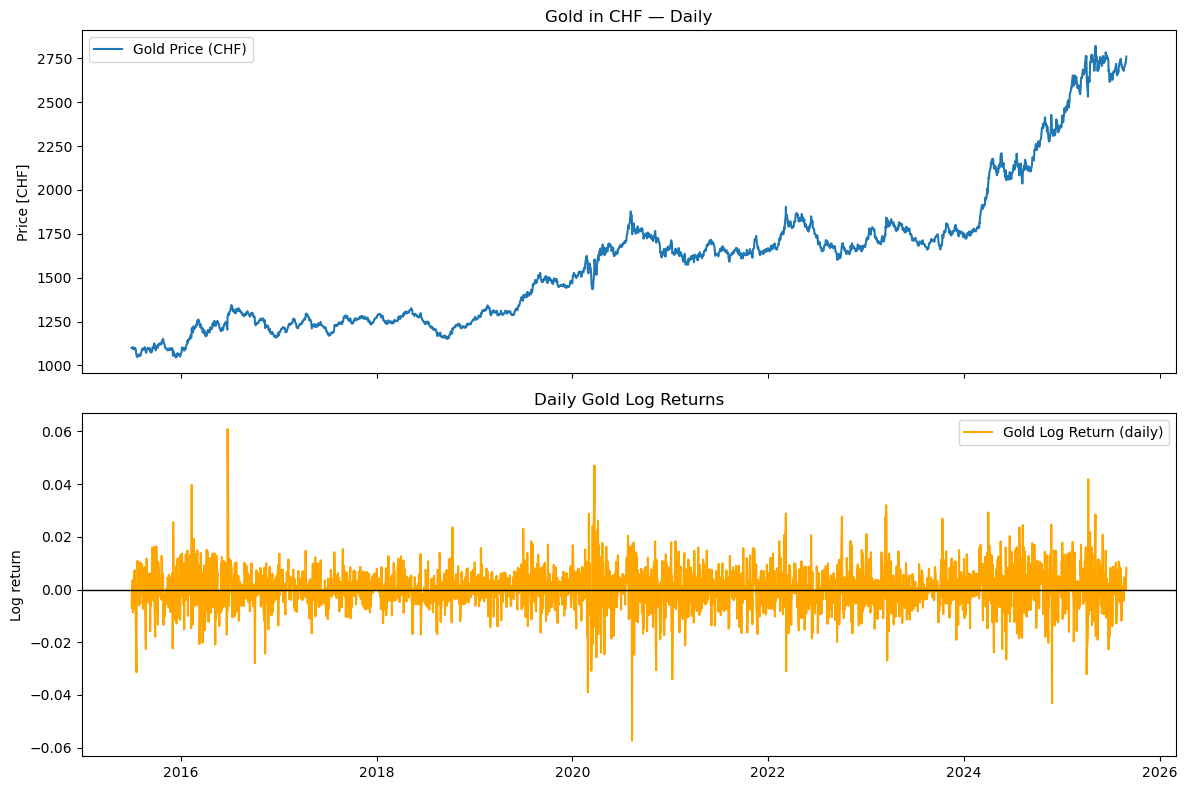

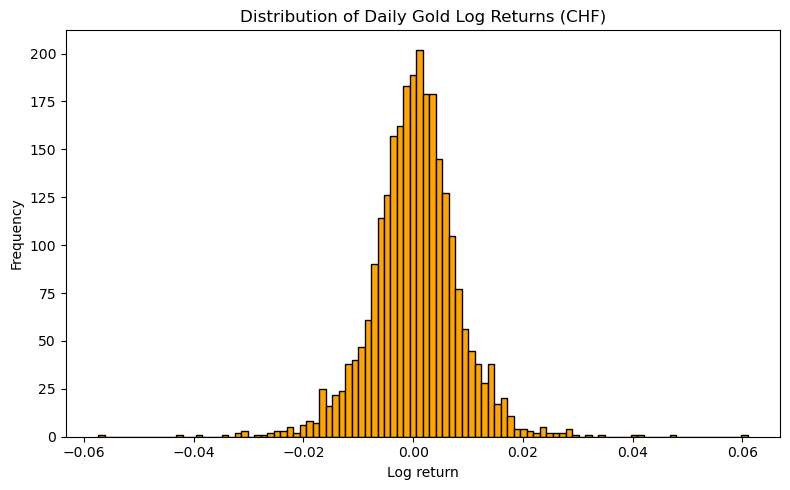

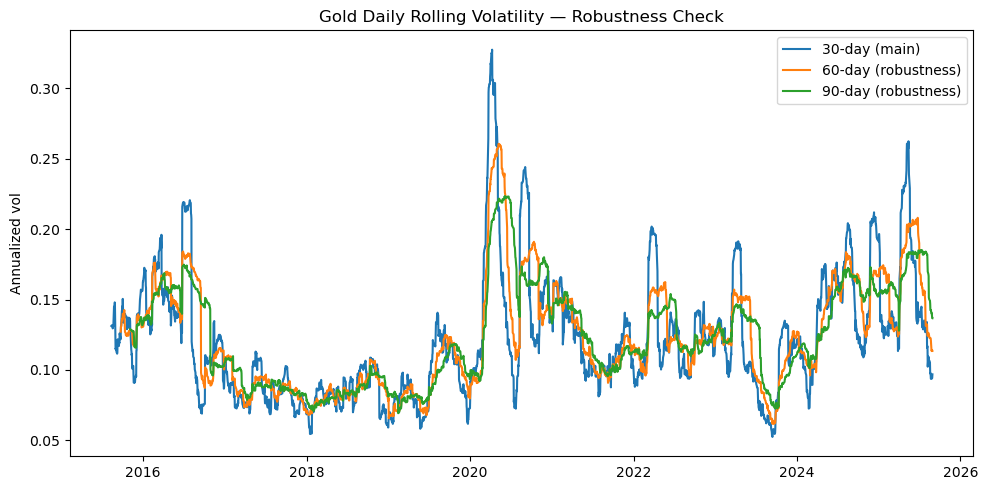

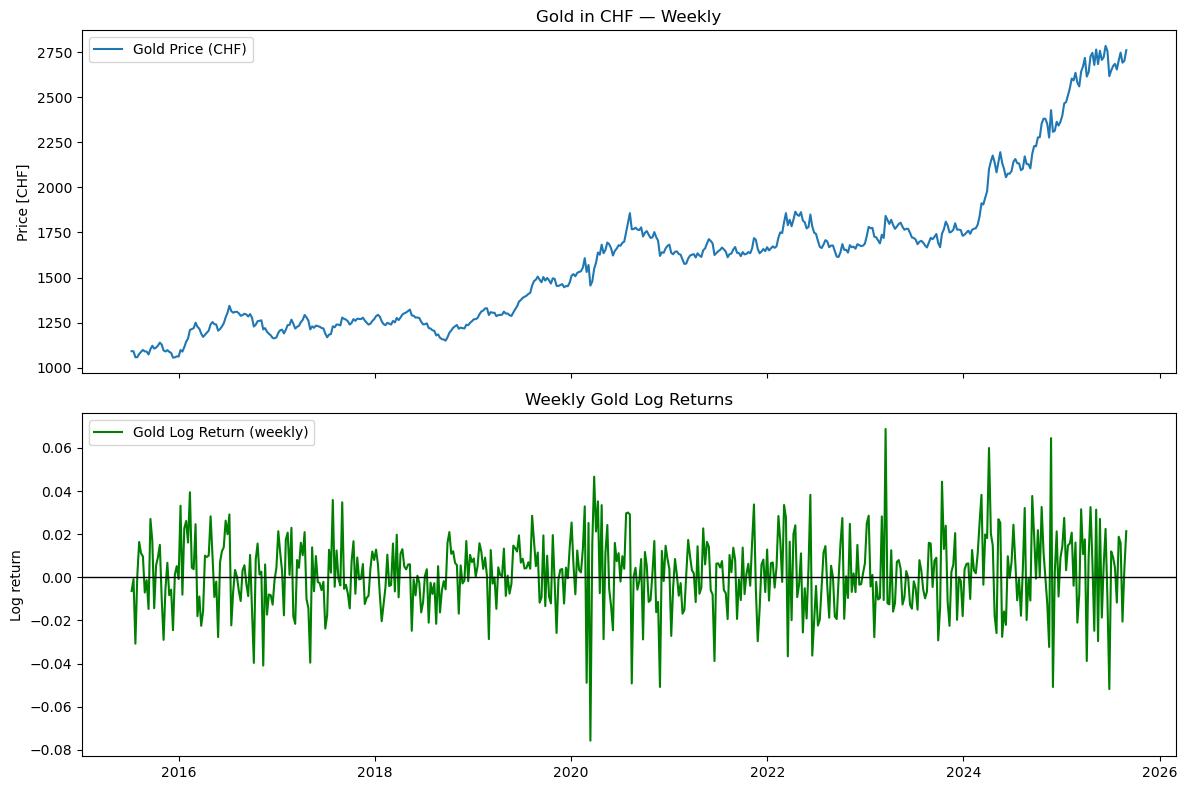

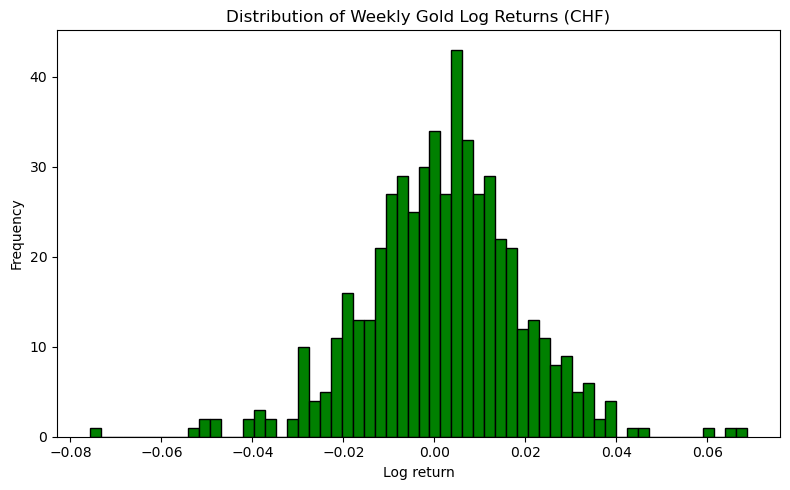

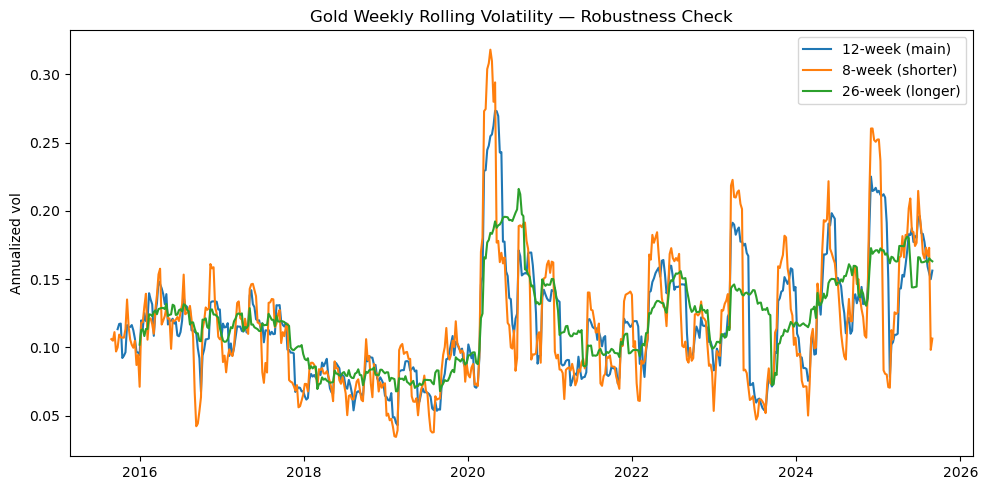

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1) Load saved Gold returns ===
path = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis_GoldCHF_returns.xlsx"
gold_d = pd.read_excel(path, sheet_name="GoldCHF daily + ret", index_col=0, parse_dates=True)
gold_w = pd.read_excel(path, sheet_name="GoldCHF weekly + ret", index_col=0, parse_dates=True)

# === 2) Descriptive statistics ===
print("=== Daily GOLD Log Returns (CHF) ===")
print(gold_d['Gold_ret'].describe())
print("\n=== Weekly GOLD Log Returns (CHF) ===")
print(gold_w['Gold_ret'].describe())

# === 3) Daily: price & returns ===
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(gold_d.index, gold_d['Gold_CHF_Last'], label='Gold Price (CHF)')
ax[0].set_title('Gold in CHF — Daily')
ax[0].set_ylabel('Price [CHF]')
ax[0].legend()

ax[1].plot(gold_d.index, gold_d['Gold_ret'], color='orange', label='Gold Log Return (daily)')
ax[1].axhline(0, color='black', lw=1)
ax[1].set_title('Daily Gold Log Returns')
ax[1].set_ylabel('Log return')
ax[1].legend()
plt.tight_layout(); plt.show()

# === 4) Daily histogram ===
plt.figure(figsize=(8,5))
plt.hist(gold_d['Gold_ret'].dropna(), bins=100, color='orange', edgecolor='black')
plt.title('Distribution of Daily Gold Log Returns (CHF)')
plt.xlabel('Log return'); plt.ylabel('Frequency')
plt.tight_layout(); plt.show()

# === 5) Daily rolling vol (30d main) + robustness (60/90d), annualized √252 ===
gold_d['RollingVol30'] = gold_d['Gold_ret'].rolling(30).std()
gold_d['RollingVol60'] = gold_d['Gold_ret'].rolling(60).std()
gold_d['RollingVol90'] = gold_d['Gold_ret'].rolling(90).std()

plt.figure(figsize=(10,5))
plt.plot(gold_d.index, gold_d['RollingVol30'] * np.sqrt(252), label='30-day (main)')
plt.plot(gold_d.index, gold_d['RollingVol60'] * np.sqrt(252), label='60-day (robustness)')
plt.plot(gold_d.index, gold_d['RollingVol90'] * np.sqrt(252), label='90-day (robustness)')
plt.title('Gold Daily Rolling Volatility — Robustness Check'); plt.ylabel('Annualized vol')
plt.legend(); plt.tight_layout(); plt.show()

# === 6) Weekly: price & returns ===
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(gold_w.index, gold_w['Gold_CHF_Last'], label='Gold Price (CHF)')
ax[0].set_title('Gold in CHF — Weekly')
ax[0].set_ylabel('Price [CHF]')
ax[0].legend()

ax[1].plot(gold_w.index, gold_w['Gold_ret'], color='green', label='Gold Log Return (weekly)')
ax[1].axhline(0, color='black', lw=1)
ax[1].set_title('Weekly Gold Log Returns')
ax[1].set_ylabel('Log return')
ax[1].legend()
plt.tight_layout(); plt.show()

# === 7) Weekly histogram ===
plt.figure(figsize=(8,5))
plt.hist(gold_w['Gold_ret'].dropna(), bins=60, color='green', edgecolor='black')
plt.title('Distribution of Weekly Gold Log Returns (CHF)')
plt.xlabel('Log return'); plt.ylabel('Frequency')
plt.tight_layout(); plt.show()

# === 8) Weekly rolling vol (12w main) + robustness (8/26w), annualized √52 ===
gold_w['RollingVol12w'] = gold_w['Gold_ret'].rolling(12).std()
gold_w['RollingVol8w']  = gold_w['Gold_ret'].rolling(8).std()
gold_w['RollingVol26w'] = gold_w['Gold_ret'].rolling(26).std()

plt.figure(figsize=(10,5))
plt.plot(gold_w.index, gold_w['RollingVol12w'] * np.sqrt(52), label='12-week (main)')
plt.plot(gold_w.index, gold_w['RollingVol8w']  * np.sqrt(52), label='8-week (shorter)')
plt.plot(gold_w.index, gold_w['RollingVol26w'] * np.sqrt(52), label='26-week (longer)')
plt.title('Gold Weekly Rolling Volatility — Robustness Check'); plt.ylabel('Annualized vol')
plt.legend(); plt.tight_layout(); plt.show()
